In [1]:
# Импорт необходимых библиотек
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
if tf.config.list_physical_devices('GPU'):
    print(tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow GPU not found!")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
%%time
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: user 362 ms, sys: 191 ms, total: 553 ms
Wall time: 901 ms


In [5]:
%%time
with tf.device('/CPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: user 0 ns, sys: 1.96 ms, total: 1.96 ms
Wall time: 1.33 ms


In [6]:
# Загрузка CIFAR-10 датасета
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [7]:
# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [8]:
train_labels.shape, test_labels.shape,

((50000, 10), (10000, 10))

In [9]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [10]:
# Выполнение аугментации данных с использованием datagen
datagen.fit(train_images)

# Пример использования .flow() для обучения модели
# model.fit(datagen.flow(train_images, train_labels, batch_size=32), steps_per_epoch=len(train_images) / 32, epochs=10)

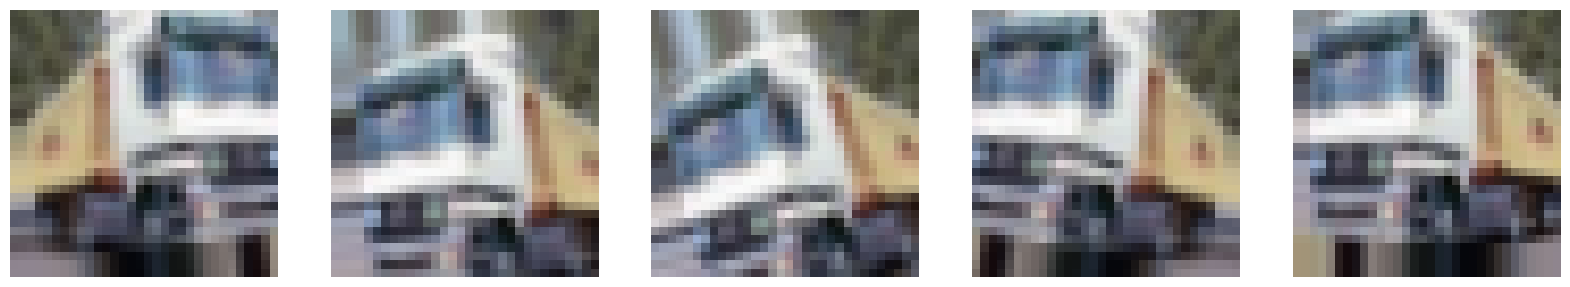

In [11]:
# Генерация аугментированных изображений
augmented_images = [train_images[1] for i in range(5)]
augmented_images = np.array(augmented_images)
augmented_images = datagen.flow(augmented_images, batch_size=5, shuffle=False).next()

# Визуализация изображений
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axarr[i].imshow(augmented_images[i])
    axarr[i].axis('off')

plt.show()


In [12]:
test_images.shape

(10000, 32, 32, 3)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), padding = "same", 
           activation='relu',
           strides = 2,
           input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels))


Epoch 1/10
1562/1562 [==============================] - 23s 13ms/step - loss: 1.6705 - accuracy: 0.3828 - val_loss: 1.3616 - val_accuracy: 0.4996
Epoch 2/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.3620 - accuracy: 0.5052 - val_loss: 1.1912 - val_accuracy: 0.5711
Epoch 3/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.2594 - accuracy: 0.5479 - val_loss: 1.1907 - val_accuracy: 0.5780
Epoch 4/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.1958 - accuracy: 0.5717 - val_loss: 1.0954 - val_accuracy: 0.6072
Epoch 5/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.1565 - accuracy: 0.5882 - val_loss: 1.1442 - val_accuracy: 0.5954
Epoch 6/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.1265 - accuracy: 0.6007 - val_loss: 1.0516 - val_accuracy: 0.6275
Epoch 7/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0982 - accuracy: 0.6087 - val_loss: 1.1240 -

1/1 [==============================] - 0s 195ms/step


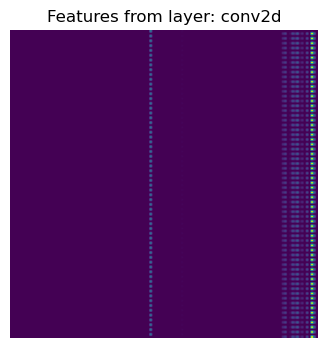

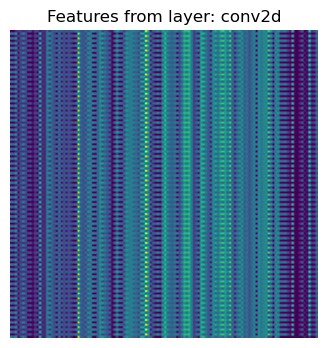

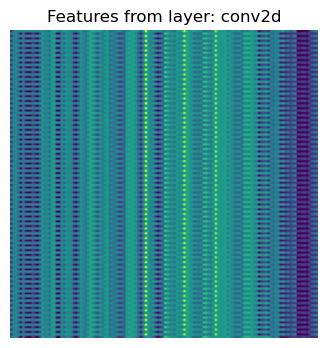

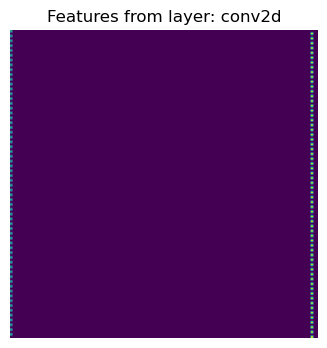

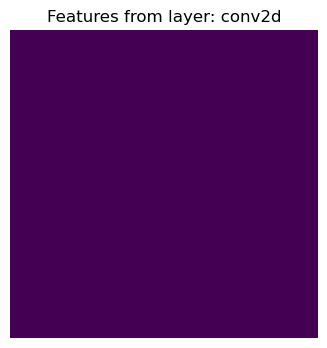

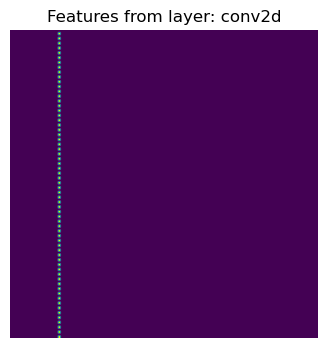

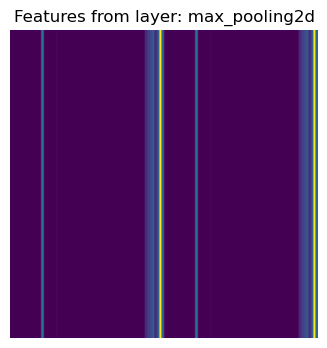

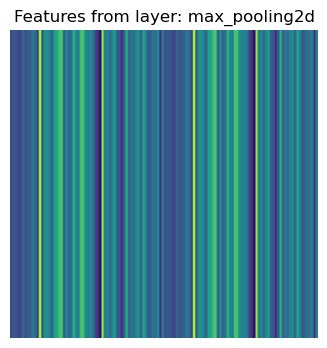

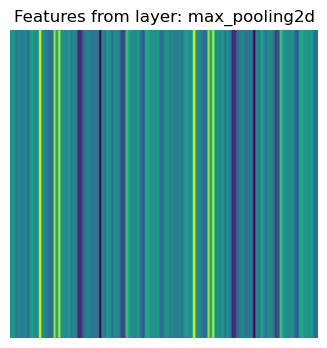

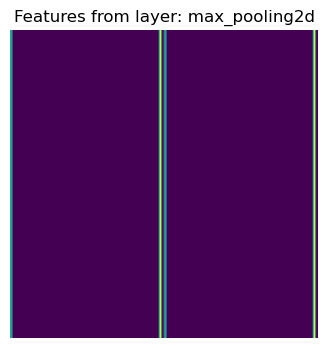

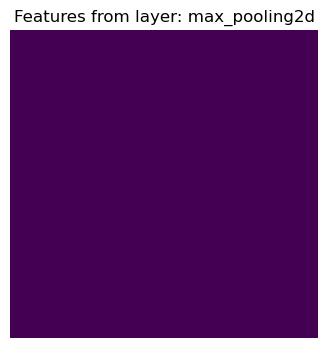

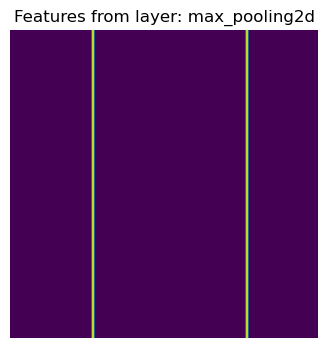

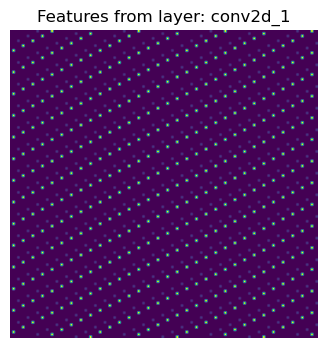

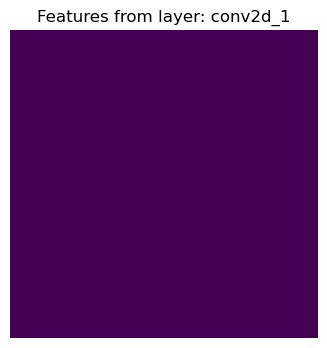

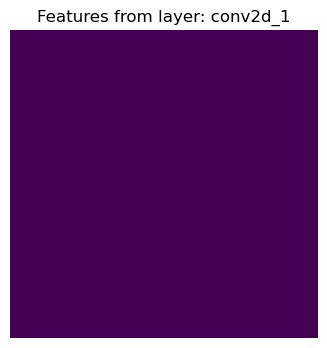

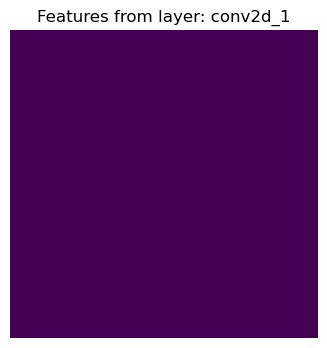

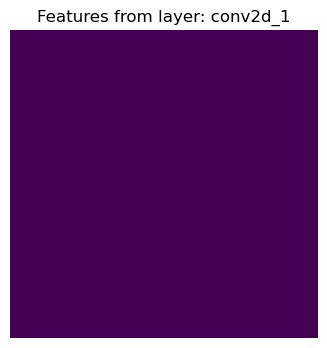

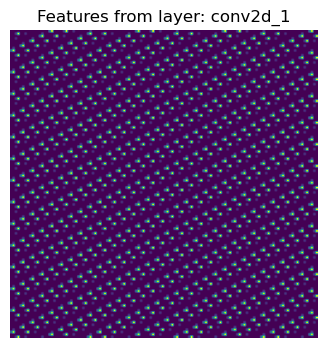

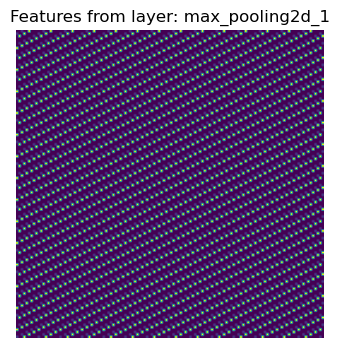

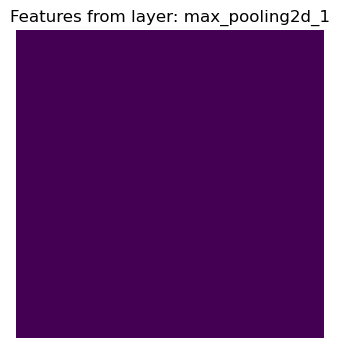

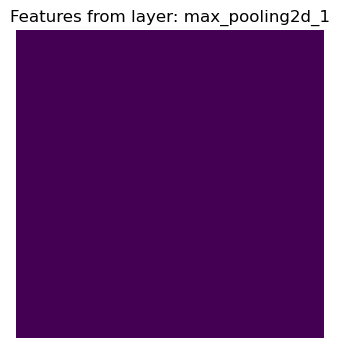

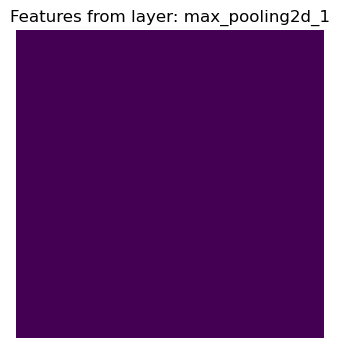

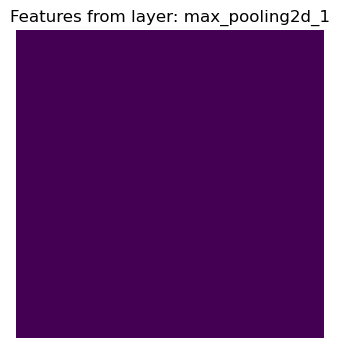

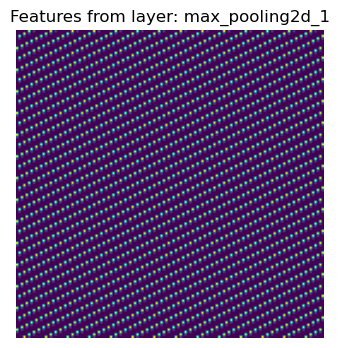

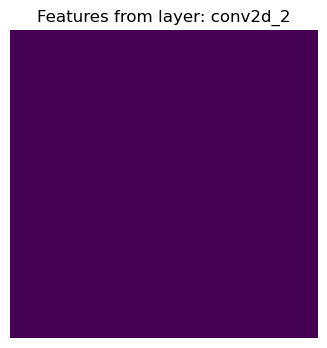

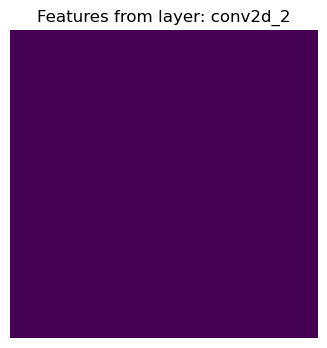

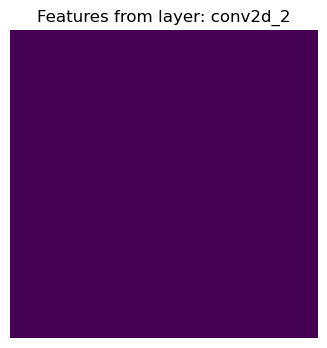

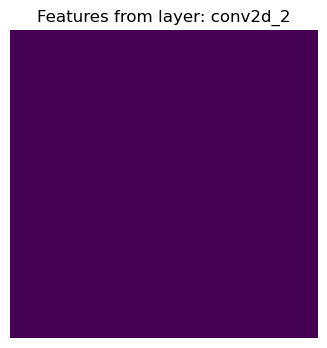

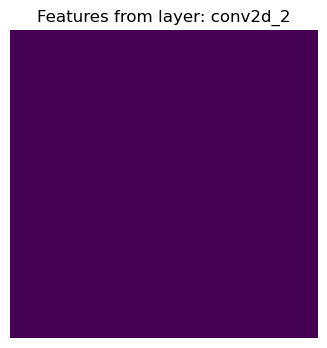

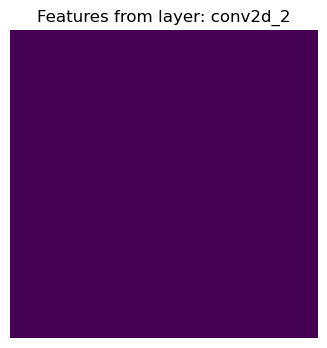

In [14]:
# Выберем одно изображение для визуализации признаков
img = train_images[0]
img = np.expand_dims(img, axis=0)  # расширим измерения для соответствия входному формату модели

# Получим выходные данные каждого слоя для выбранного изображения
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

# Функция для интерполяции изображений до размера 128x128
def upscale_to_128x128(img):
    return np.resize(img, (128, 128))

# Визуализация признаков
for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    # Если активация имеет 4 измерения (как в случае с Conv2D и MaxPooling2D)
    if len(layer_activation.shape) == 4:
        # Выберем первые 6 признаковых карт для визуализации
        for i in range(6):
            plt.figure(figsize=(16, 4))
            
            # Некоторые слои могут иметь менее 6 каналов, в таком случае мы визуализируем только имеющиеся
            if layer_activation.shape[-1] >= i+1:
                channel_image = layer_activation[0, :, :, i]
                channel_image = upscale_to_128x128(channel_image)  # Интерполяция до размера 128x128
                plt.imshow(channel_image, cmap='viridis')
                plt.title(f"Features from layer: {layer_name}")
                plt.axis('off')
        plt.show()


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбека
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping])

Epoch 1/10
1562/1562 [==============================] - 20s 12ms/step - loss: 1.6416 - accuracy: 0.3975 - val_loss: 1.3410 - val_accuracy: 0.5207
Epoch 2/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.3038 - accuracy: 0.5337 - val_loss: 1.1359 - val_accuracy: 0.5960
Epoch 3/10
1562/1562 [==============================] - 21s 13ms/step - loss: 1.1926 - accuracy: 0.5743 - val_loss: 1.0617 - val_accuracy: 0.6317
Epoch 4/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1299 - accuracy: 0.5998 - val_loss: 1.0259 - val_accuracy: 0.6410
Epoch 5/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0769 - accuracy: 0.6181 - val_loss: 1.0082 - val_accuracy: 0.6480
Epoch 6/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.0332 - accuracy: 0.6364 - val_loss: 0.9479 - val_accuracy: 0.6680
Epoch 7/10
1562/1562 [==============================] - 19s 12ms/step - loss: 0.9866 - accuracy: 0.6513 - val_loss: 0.9128 -

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr])


Epoch 1/10
1562/1562 [==============================] - 21s 13ms/step - loss: 1.6333 - accuracy: 0.4014 - val_loss: 1.3017 - val_accuracy: 0.5280 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.3047 - accuracy: 0.5328 - val_loss: 1.1562 - val_accuracy: 0.5879 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.1825 - accuracy: 0.5795 - val_loss: 1.0093 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1079 - accuracy: 0.6035 - val_loss: 0.9927 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 5/10
1562/1562 [==============================] - 21s 14ms/step - loss: 1.0552 - accuracy: 0.6260 - val_loss: 0.9771 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 6/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.0075 - accuracy: 0.6452 - val_loss: 0.8838 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 7/10
1562/1562 [========================

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback])

Epoch 1/10
1562/1562 [==============================] - 21s 13ms/step - loss: 1.6107 - accuracy: 0.4075 - val_loss: 1.3518 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.3233 - accuracy: 0.5257 - val_loss: 1.1354 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1981 - accuracy: 0.5732 - val_loss: 1.0972 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.1250 - accuracy: 0.6005 - val_loss: 1.0187 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 5/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.0732 - accuracy: 0.6192 - val_loss: 0.9965 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 6/10
1562/1562 [==============================] - 20s 13ms/step - loss: 1.0368 - accuracy: 0.6347 - val_loss: 0.9064 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 7/10
1562/1562 [========================

In [20]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4002), started 3:01:50 ago. (Use '!kill 4002' to kill it.)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Добавление ModelCheckpoint callback
best_model_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback,checkpoint_callback])